# BINGO CELL IMG CLASSIFICATION

### GPU check

In [41]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-01-15 22:14:58.114770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 22:14:58.115481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 22:14:58.116154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 22:14:58.116895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 22:14:58.117657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4215791120818888978
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2078015488
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16705954386574590962
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

### Import Libraries

In [42]:
import matplotlib.pyplot as plt
import datetime
from keras.utils.vis_utils import plot_model
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import time
import random
import numpy as np
import glob

### 乱数固定

In [43]:
def set_seed(seed=200):
    tf.random.set_seed(seed)

    # optional
    # for numpy.random
    np.random.seed(seed)
    
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(7)

# To avoid "Allocation of X exceeds 10% of free system memory."
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### About dataset

In [44]:
TRAINING_DIR = "./train-dataset"
VALIDATION_DIR = "./valid-dataset"

sum_train_num_files = 0
sum_valid_num_files = 0
for num in range(1, 76):
    train_num_files = len(glob.glob(f'{TRAINING_DIR}/{num}/*.jpg'))
    valid_num_files = len(glob.glob(f'{VALIDATION_DIR}/{num}/*.jpg'))
    print(f"{num}: {train_num_files}, {valid_num_files}")
    sum_train_num_files += train_num_files
    sum_valid_num_files += valid_num_files
print(f"sum: {sum_train_num_files}, {sum_valid_num_files}")

1: 22, 5
2: 37, 5
3: 36, 5
4: 24, 5
5: 34, 5
6: 36, 5
7: 38, 5
8: 24, 5
9: 20, 5
10: 39, 5
11: 26, 5
12: 31, 5
13: 51, 5
14: 24, 5
15: 25, 5
16: 47, 5
17: 23, 5
18: 19, 5
19: 30, 5
20: 49, 5
21: 32, 5
22: 42, 5
23: 25, 5
24: 28, 5
25: 17, 5
26: 23, 5
27: 15, 5
28: 25, 5
29: 33, 5
30: 38, 5
31: 20, 5
32: 23, 5
33: 26, 5
34: 41, 5
35: 28, 5
36: 27, 5
37: 32, 5
38: 39, 5
39: 20, 5
40: 37, 5
41: 14, 5
42: 29, 5
43: 23, 5
44: 21, 5
45: 37, 5
46: 22, 5
47: 24, 5
48: 40, 5
49: 44, 5
50: 33, 5
51: 38, 5
52: 38, 5
53: 20, 5
54: 33, 5
55: 44, 5
56: 59, 5
57: 39, 5
58: 28, 5
59: 35, 5
60: 35, 5
61: 41, 5
62: 47, 5
63: 39, 5
64: 29, 5
65: 23, 5
66: 44, 5
67: 34, 5
68: 31, 5
69: 37, 5
70: 31, 5
71: 27, 5
72: 18, 5
73: 36, 5
74: 22, 5
75: 17, 5
sum: 2338, 375


### Parameters

In [45]:
date_now = str(datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

# info
VERBOSE = 1
IMG_SIZE = (80, 80)
MODEL_SAVE_DIR = f"./models/{date_now}"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

NUM_CLASSES = 75
TRAIN_IMAGES = sum_train_num_files
VALID_IMAGES = sum_valid_num_files

# params
data_generator_param = {
    "rescale": 1 / 256,  # 各ピクセルの値を0以上1以下に正規化(一般的な画像データは256階調で画素の明るさを表現しているから)
    "rotation_range": 3,
    "width_shift_range": 0.05,
    "height_shift_range": 0.05,
    "shear_range": 0.05,
    "zoom_range": 0.05,
    "fill_mode": "nearest",
}
EPOCHS = 100
TRAIN_BATCHSIZE = 3
VAL_BATCHSIZE = 1

STEPS_PER_EPOCH = TRAIN_IMAGES // TRAIN_BATCHSIZE
VALIDATION_STEPS = VALID_IMAGES // VAL_BATCHSIZE

LOSS = 'categorical_crossentropy'
OPTIMIZER = 'rmsprop'
METRICS = 'accuracy'

In [46]:
training_datagenerator = ImageDataGenerator(**data_generator_param)
validation_datagenerator = ImageDataGenerator(**data_generator_param)
generated_train_data = training_datagenerator.flow_from_directory(  # training_datagenの定義を用いて写真を変更し保存
    TRAINING_DIR,  # 学習する画像のフォルダを指定
    target_size=IMG_SIZE,  # 画像データのサイズ
    # "categorical"か"binary"か"sparse"か"input"か"other"か"None"のいずれか1つ．"categorical"は2次元のone-hotにエンコード化されたラベル
    class_mode='categorical',
    batch_size=TRAIN_BATCHSIZE  # batch_sizeはミニバッチ学習に使われるバッチのサイズ。
)
generated_vali_data = validation_datagenerator.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=VAL_BATCHSIZE
)

Found 2338 images belonging to 75 classes.
Found 375 images belonging to 75 classes.


### Callback

In [47]:
eary_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, verbose=1, mode='auto')

tensor_board_cb = tf.keras.callbacks.TensorBoard(log_dir=MODEL_SAVE_DIR, histogram_freq=1)

fpath = 'weight-{epoch:02d}-{loss:.2f}-{accuracy:.2f}-{val_loss:.2f}-{val_accuracy:.2f}.h5'
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_SAVE_DIR, fpath), monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

callbacks = [eary_stopping_cb, tensor_board_cb, model_checkpoint_cb]

#### Tensorboardの使い方
```
tensorboard --logdir  ./programs/ML/models/
```

### モデルの定義

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 78, 78, 64)        1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 39, 39, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 18, 18, 128)      0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 41472)             0         
                                                                 
 dropout_4 (Dropout)         (None, 41472)            

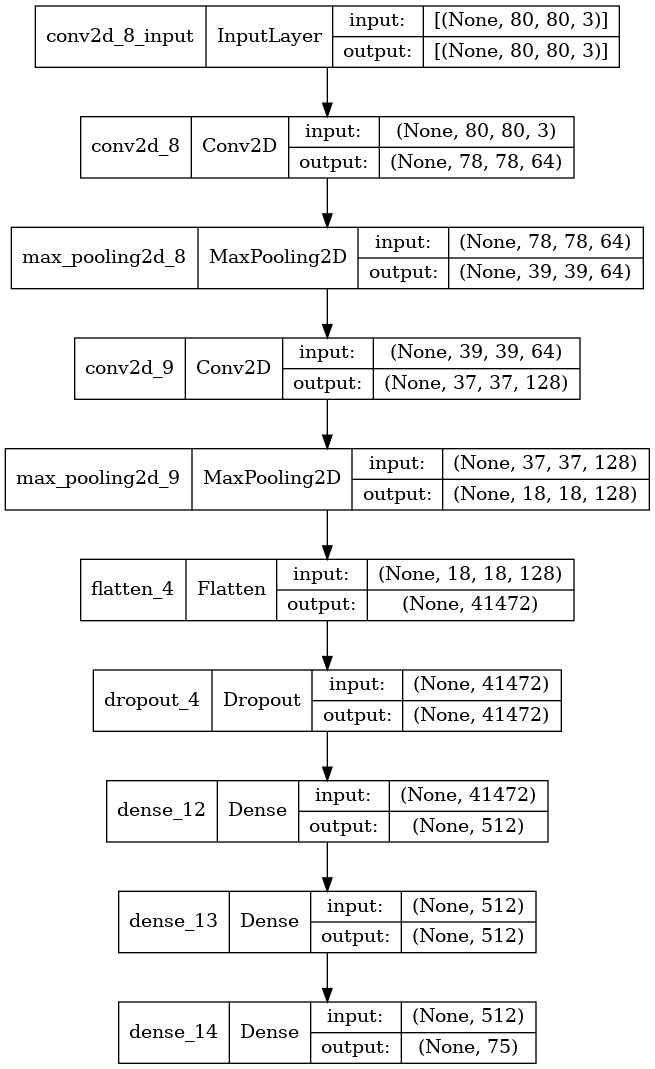

In [48]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        64, (3, 3), activation='relu', input_shape=(
            80, 80, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
model.summary()

date_now = str(datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
plot_model(model, to_file=f'{MODEL_SAVE_DIR}/' + "NN-model-summary.png", show_shapes=True)

### 学習

In [ ]:
start_time = time.time()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[METRICS])
history = model.fit(generated_train_data,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=generated_vali_data,
                    verbose=VERBOSE,
                    validation_steps=VALIDATION_STEPS,
                    callbacks=callbacks,
                    )
print(f"{(time.time()-start_time)/60} min")

Epoch 1/100
777/779 [============================>.] - ETA: 0s - loss: 4.2228 - accuracy: 0.0404
Epoch 00001: val_loss improved from inf to 3.79007, saving model to ./models/20220115-221458/weight-01-4.22-0.04-3.79-0.09.h5
779/779 [==============================] - 21s 27ms/step - loss: 4.2214 - accuracy: 0.0403 - val_loss: 3.7901 - val_accuracy: 0.0907
Epoch 2/100
779/779 [==============================] - ETA: 0s - loss: 2.7393 - accuracy: 0.2745
Epoch 00002: val_loss improved from 3.79007 to 1.97385, saving model to ./models/20220115-221458/weight-02-2.74-0.27-1.97-0.42.h5
779/779 [==============================] - 20s 26ms/step - loss: 2.7393 - accuracy: 0.2745 - val_loss: 1.9738 - val_accuracy: 0.4187
Epoch 3/100
777/779 [============================>.] - ETA: 0s - loss: 1.3612 - accuracy: 0.6157
Epoch 00003: val_loss improved from 1.97385 to 1.02948, saving model to ./models/20220115-221458/weight-03-1.36-0.62-1.03-0.71.h5
779/779 [==============================] - 20s 26ms/step 

### 精度の確認

In [ ]:
model.save(
    os.path.join(
        MODEL_SAVE_DIR,
        "weight-final.h5"))  # モデルの保存(h5形式)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, loss, 'g', label="Training loss")
plt.plot(epochs, val_loss, 'm', label="Validation loss")
plt.title('Training and validation accuracy and loss')
plt.legend(loc=0)
plt.savefig(f'{MODEL_SAVE_DIR}/' 'accuracy.png')
plt.show()
